In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fast')

from sklearn.impute import KNNImputer
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import silhouette_score
from scipy.spatial import ConvexHull 

from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, PredictionErrorDisplay,  davies_bouldin_score
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression

from sklearn.ensemble import GradientBoostingRegressor
import optuna
from optuna.samplers import TPESampler

In [3]:
import os, sys
# Hides output while after model learned
from IPython.display import clear_output

# Display fixed length of a dataframe
pd.set_option("display.max_rows", 9, "display.max_columns", 9)

#set path
sys.path.insert(1, '../')

from utils.config_reader import config_reader
# Import parameters
config = config_reader('../config/config.json')
random_seed = config.random_seed
figures_path = config.figures_path
sampler = TPESampler(seed=random_seed) # fix random seed
df = pd.read_csv(config.data_path + 'segmentation.zip')


In [4]:
data = df.copy()
data.sample(5)

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,...,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
6344,C16519,1527.826042,1.000000,3191.00,...,5393.198816,436.082971,0.083333,12
7159,C17353,42.170547,1.000000,588.00,...,611.475897,164.424956,0.636364,12
2332,C12405,4395.237251,1.000000,2514.30,...,2095.014385,1960.982734,0.000000,12
5571,C15727,20.700474,0.857143,94.98,...,86.167530,104.771473,0.500000,7
8381,C18605,41.479055,1.000000,243.96,...,1146.784474,132.697082,0.400000,12


**Feature description**
* CUST_ID: Credit card holder ID
* BALANCE: Monthly average balance (based on daily balance averages)
* BALANCE_FREQUENCY: Ratio of the last 12 months with balance within the scale from [0,1], where 1 = frequently updated, 0 = not frequently updated
* PURCHASES: Total purchase amount spent during last 12 months
* ONEOFF_PURCHASES: Total amount of one-off purchases
* INSTALLMENTS_PURCHASES: Total amount of installment purchases
* CASH_ADVANCE: Total cash-advance amount
* PURCHASES_ FREQUENCY: Frequency of purchases (Percent of months with at least one purchase)
* ONEOFF_PURCHASES_FREQUENCY: Frequency of one-off-purchases 
* PURCHASES_INSTALLMENTS_FREQUENCY: Frequency of installment purchases
* CASH_ADVANCE_ FREQUENCY: Cash-Advance frequency
* AVERAGE_PURCHASE_TRX: Average amount per purchase transaction
* CASH_ADVANCE_TRX: Average amount per cash-advance transaction
* PURCHASES_TRX: Average amount per purchase transaction
* CREDIT_LIMIT: Credit limit
* PAYMENTS: Total payments (due amount paid by the customer to decrease their statement balance) in the period
* MINIMUM_PAYMENTS: Total minimum amount due in the period that the credit user have to pay to keep its account in good standing.
* PRC_FULL_PAYMENTS: Percentage of months with full payment of the due statement balance (0 = rare, 1 = always repaid)
* TENURE: Number of months as a customer

In [5]:
print(data.shape)
data.info()

(8950, 18)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  


In [6]:
display(data['CUST_ID'].duplicated().value_counts())

data.drop(['CUST_ID'], axis=1, inplace=True)

False    8950
Name: CUST_ID, dtype: int64

In [7]:
data['TENURE'].value_counts()

12    7584
11     365
10     236
6      204
8      196
7      190
9      175
Name: TENURE, dtype: int64

## Missed values

In [8]:
cols_null_val = data.isnull().sum()
cols_with_null = cols_null_val[cols_null_val > 0].sort_values(ascending=False)
display(cols_with_null)


MINIMUM_PAYMENTS    313
CREDIT_LIMIT          1
dtype: int64

In [9]:
print('Total missed entries: {}'.format(data.isna().sum().sum()))

Total missed entries: 314


In [10]:
imputer =  KNNImputer(n_neighbors=5, weights="uniform", metric='nan_euclidean')
data = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)

# check if nan are present in the dataset
for i in data.columns:
    assert data[i].isna().sum()== 0
    
data.shape

(8950, 17)

## categorical data

In [11]:
data['TENURE'].value_counts()

12.0    7584
11.0     365
10.0     236
6.0      204
8.0      196
7.0      190
9.0      175
Name: TENURE, dtype: int64

## Scaling

In [12]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data)
X_scaled = pd.DataFrame(X_scaled, columns=data.columns)
X_scaled.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,...,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,-0.731989,-0.249434,-0.424900,-0.356934,...,-0.528979,-0.303812,-0.525551,0.36068
1,0.786961,0.134325,-0.469552,-0.356934,...,0.818642,0.093556,0.234227,0.36068
2,0.447135,0.518084,-0.107668,0.108889,...,-0.383805,-0.096029,-0.525551,0.36068
3,0.049099,-1.016953,0.232058,0.546189,...,-0.598688,-0.201440,-0.525551,0.36068
4,-0.358775,0.518084,-0.462063,-0.347294,...,-0.364368,-0.258964,-0.525551,0.36068


## clusterization

### K-means

In [13]:
def get_silhouette(cluster_num:int, data:pd.DataFrame)->float:
    """Get silhouette metrics with k-means algorythm 

    Args:
        cluster_num (int): given number of clusters
        X (pd.DataFrame): features

    Returns:
        float: silhouette metrics
    """    
    k_means =  KMeans(n_clusters=cluster_num, init='k-means++', n_init=10, random_state=random_seed).fit(data)

    return silhouette_score(data, k_means.predict(data)), k_means.inertia_


silhouette_res = {"silhouette": [], "cluster": [], 'inertia':[]}

for cluster_num in range(2, 10):
    silhouette_res["cluster"].append(cluster_num)
    silhouette_res["silhouette"].append(get_silhouette(cluster_num, X_scaled)[0])
    silhouette_res["inertia"].append(get_silhouette(cluster_num, X_scaled)[1])
    
silhouette_df = pd.DataFrame(silhouette_res)
silhouette_df.head()

,silhouette,cluster,inertia
0,0.209335,2,127784.560129
1,0.250380,3,111968.157650
2,0.197457,4,99059.236483
3,0.193129,5,91491.249068
4,0.202477,6,84819.895642


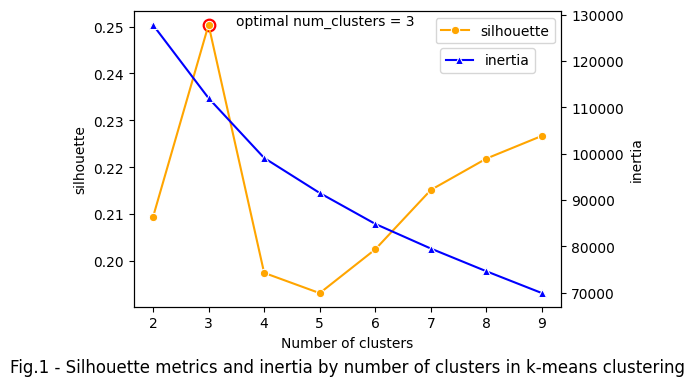

In [14]:
plot_counter = 1

fig, ax = plt.subplots(figsize = (6, 4))
fig = sns.lineplot(data=silhouette_df, x="cluster", y="silhouette", marker= "o",ax=ax, c='orange', label='silhouette')

# highlight the optimum value
xx,yy =  np.argmax(silhouette_df['silhouette'].values), np.max(silhouette_df['silhouette'].values)
plt.scatter(x=xx+2, y=yy, marker= "o", c='r',s=80)
plt.annotate(f'optimal num_clusters = {xx+2}', xy=(xx+2+0.5, yy))
minor_ticks = np.arange(1, 9, 0.5)
major_ticks = np.arange(2, 10, 1)
#ax.set_xticks(minor_ticks, minor=True)
fig.set_xlabel('Number of clusters')
ax.set_title(f'Fig.{plot_counter} - Silhouette metrics and inertia by number of clusters in k-means clustering', y=-0.25)

ax2 = ax.twinx() 
fig = sns.lineplot(data=silhouette_df, x="cluster", y="inertia", marker= "^",ax=ax2, c='b', label='inertia')
sns.move_legend(fig, "upper left", bbox_to_anchor=(.70, .9))
plt.tight_layout();
#ax.grid(which='major', alpha=0.9);

plt.savefig(os.path.join(figures_path, f'fig_{plot_counter}.png'))

In [15]:
# from yellowbrick.cluster import KElbowVisualizer

# fig = plt.figure(figsize=(6,4))
# Elbow_M = KElbowVisualizer(KMeans(n_init=10, random_state=random_seed), k=20, timings=False)
# Elbow_M.fit(X_scaled)
# Elbow_M.show();

<center> <img src = "../figures/fig_2.png"  alt="drawing" style="width:450px;"> </center>

> Clustering using the elbow method returns 3 clusters that is easy to use and understand. By contrast with the elbow method, clustering by the distortion score and inertia  do not indicate a distinct optimal number of clusters.

In [16]:
# create clustering instance
kmeans = KMeans( n_clusters=3, n_init=10, random_state=random_seed).fit(X_scaled)

# save clustering labels to a feature 
#X_scaled['Clusters_kmeans'] = kmeans.labels_

#X_scaled['Clusters_kmeans'].value_counts()
np.unique(kmeans.labels_, return_counts=True)

(array([0, 1, 2]), array([6118, 1596, 1236], dtype=int64))

### DBSCAN

In [17]:
db = DBSCAN().fit(X_scaled)

clusters = db.labels_
print('DBscan with default parameters returns following number of clusters: {}'.format(len(set(clusters)) - (1 if -1 in clusters else 0)))

DBscan with default parameters returns following number of clusters: 36


In [19]:
def get_silhouette_db(data:pd.DataFrame, eps:float, samples:float)->float:
    """Get silhouette metrics with the DBSCAN algorythm

    Args:
        cluster_num (int): given number of clusters
        X (pd.DataFrame): features

    Returns:
        float: silhouette metrics
    """    
    db = DBSCAN(eps=eps, min_samples=samples).fit(data)
    
    return silhouette_score(data, db.labels_, metric='euclidean')
    
silhouette_res = {"silhouette": [], "eps": [], "min_samples": [] } 

# search by given grid of parameters
for eps in np.arange(0.1,4,0.2):
    for samples in range(1,25,5):
        silhouette_res["silhouette"].append(get_silhouette_db(X_scaled, eps, samples))
        silhouette_res["eps"].append(eps)
        silhouette_res["min_samples"].append(samples)

    
silhouette_df = pd.DataFrame(silhouette_res)
silhouette_df.sort_values(by='silhouette', ascending=False)

best_params = silhouette_df.sort_values(by='silhouette', ascending=False).values[0][1:]

print('Best parameters are: \n', best_params)

Best parameters are: 
 [3.9 6. ]


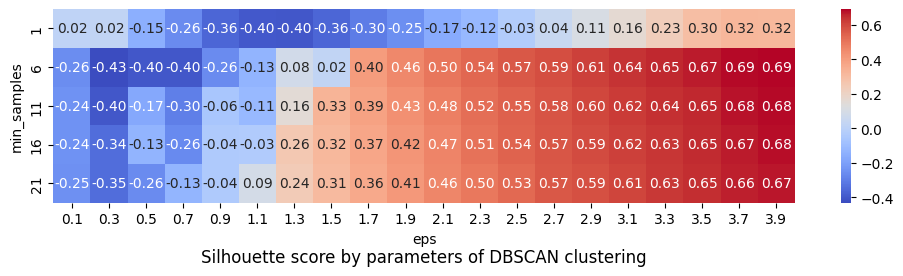

In [20]:
pivot = pd.pivot_table(data=silhouette_df,
                       columns = silhouette_df['eps'].round(1),
                       index='min_samples',
                       values='silhouette')
plt.figure(figsize=(10,3))
fig = sns.heatmap(pivot, annot=True, fmt='.02f', cmap='coolwarm')
fig.set_title(f'Silhouette score by parameters of DBSCAN clustering', y=-0.35)
plt.tight_layout();

In [21]:
db = DBSCAN(eps=2.9, min_samples=5).fit(X_scaled)
np.unique(db.labels_, return_counts=True)

(array([-1,  0], dtype=int64), array([ 224, 8726], dtype=int64))

> DBSCAN doesn't show reliable result since it assigned 97% data to 1 cluster, and the rest marked as outliers. This happens because the data is distributed by parameters 'with equal density' and, therefore, cannot be easily distinguished with the DBSCAN algorythm.

## Agglomerative clustering

In [22]:
agg_clustering = AgglomerativeClustering(n_clusters=2)
agg_clustering.fit(X_scaled)

agg_clustering.labels_ [:10]

def get_silhouette_agg(cluster_num:int, data:pd.DataFrame)->float:
    """Get silhouette metrics with Agglomerative_clustering algorythm 

    Args:
        cluster_num (int): given number of clusters
        X (pd.DataFrame): features

    Returns:
        float: silhouette metrics
    """    
    agg_clustering =  AgglomerativeClustering(n_clusters=cluster_num, metric='euclidean').fit(data)

    return silhouette_score(data, agg_clustering.labels_)

silhouette_res = {"silhouette": [], "clusters": []}

for cluster_num in range(3, 10):
    silhouette_res["silhouette"].append(get_silhouette_agg(cluster_num, X_scaled))
    silhouette_res["clusters"].append(cluster_num)
    
silhouette_df = pd.DataFrame(silhouette_res)

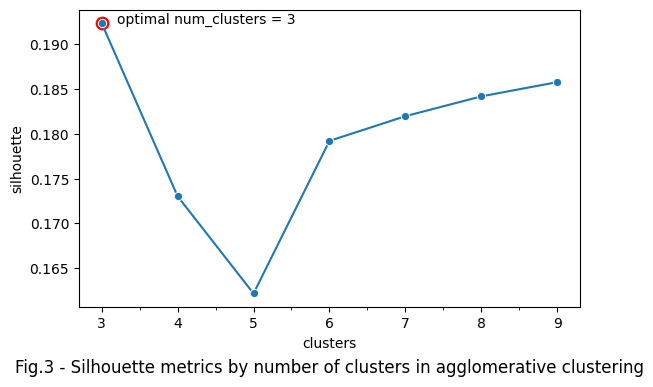

In [23]:
plot_counter = 3
fig, ax = plt.subplots(figsize = (6, 4))
fig = sns.lineplot(data=silhouette_df, x="clusters", y="silhouette", marker= "o", ax=ax)
fig.set_title(f'Fig.{plot_counter} - Silhouette metrics by number of clusters in agglomerative clustering', y=-0.25)

# highlight the optimum value
xx,yy =  np.argmax(silhouette_df['silhouette'].values), np.max(silhouette_df['silhouette'].values)
plt.scatter(x=xx+3, y=yy, marker= "o", c='r',s=80)
plt.annotate(f'optimal num_clusters = {xx+3}', xy=(xx+3.2, yy))
minor_ticks = np.arange(3, 9, 0.5)
major_ticks = np.arange(3, 10, 1)
ax.set_xticks(minor_ticks, minor=True)
#ax.grid(which='major', alpha=0.9);
plt.tight_layout();


#plt.savefig(os.path.join(figures_path, f'fig_{plot_counter}.png'))

In [24]:
agg_clustering =  AgglomerativeClustering(n_clusters=3, metric='euclidean').fit(X_scaled)
np.unique(agg_clustering.labels_, return_counts=True)

(array([0, 1, 2], dtype=int64), array([3069, 4992,  889], dtype=int64))

In [30]:
X_scaled

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,...,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,-0.731989,-0.249434,-0.424900,-0.356934,...,-0.528979,-0.303812,-0.525551,0.360680
1,0.786961,0.134325,-0.469552,-0.356934,...,0.818642,0.093556,0.234227,0.360680
2,0.447135,0.518084,-0.107668,0.108889,...,-0.383805,-0.096029,-0.525551,0.360680
3,0.049099,-1.016953,0.232058,0.546189,...,-0.598688,-0.201440,-0.525551,0.360680
...,...,...,...,...,...,...,...,...,...
8946,-0.742423,0.518084,-0.329136,-0.356934,...,-0.503396,-0.296762,-0.525551,-4.122768
8947,-0.740398,-0.185477,-0.401965,-0.356934,...,-0.570615,-0.328132,0.329200,-4.122768
8948,-0.745174,-0.185477,-0.469552,-0.356934,...,-0.580536,-0.339490,0.329200,-4.122768
8949,-0.572575,-0.889033,0.042146,0.301732,...,-0.576869,-0.325631,-0.525551,-4.122768


In [31]:
get_db_score(3, X_scaled)

AttributeError: 'numpy.ndarray' object has no attribute 'labels_'

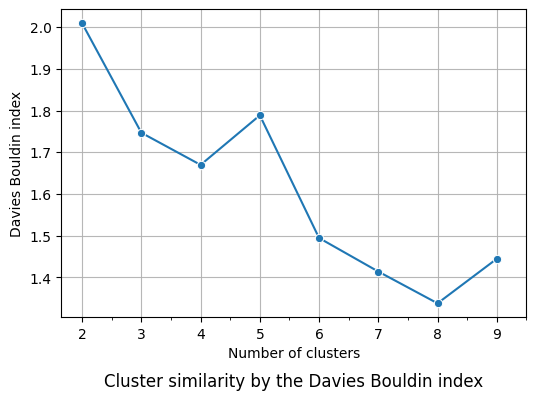

In [33]:
def get_db_score(cluster_num:int, X:pd.DataFrame)->pd.DataFrame:
    """Calculate the extent of cluster uniqueness by the davies_bouldin_score

    Args:
        cluster_num (int): number of clusters for estimation
        X (pd.DataFrame): feature matrix

    Returns:
        float: davies_bouldin_score
    """    
    agc =  AgglomerativeClustering(n_clusters=cluster_num, metric='euclidean')
    agc.fit_predict(X)
    return davies_bouldin_score(X, agc.labels_)

# empty dict to store Davies Bouldin indexes and numbers of clusters
db_res = {"db_score": [], "cluster": []}

 
for cluster_num in range(2, 10):
    db_res["db_score"].append(get_db_score(cluster_num, X_scaled))
    db_res["cluster"].append(cluster_num)
    
 
db_df = pd.DataFrame(db_res)

fig, ax = plt.subplots(figsize = (6, 4))

sns.lineplot(data=db_df, x="cluster", y="db_score", marker= "o",ax=ax)

minor_ticks = np.arange(2, 10, 0.5)
major_ticks = np.arange(2, 10, 1)
ax.set_xticks(minor_ticks, minor=True)
ax.grid(which='major', alpha=0.9)
ax.set_ylabel('Davies Bouldin index')
ax.set_xlabel('Number of clusters')
ax.set_title('Agglomerative clusters similarity by the Davies Bouldin index', y=-0.25);
#ax.grid(which='minor', alpha=0.2);

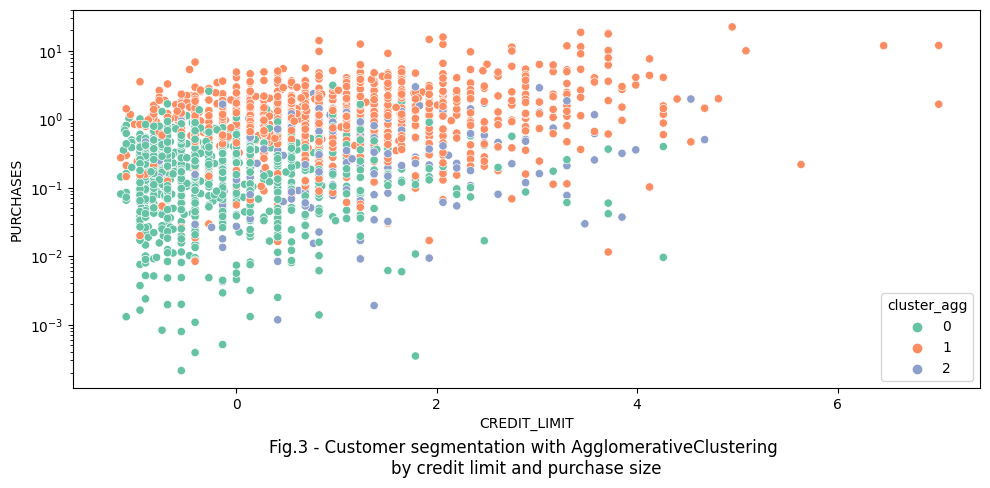

In [30]:
agg_clustering =  AgglomerativeClustering(n_clusters=3, metric='euclidean').fit(X_scaled)
agg_clustering.fit(X_scaled)
X_scaled['cluster_agg'] = agg_clustering.labels_

plot_counter = 3

plt.figure(figsize=(10,5))
fig = sns.scatterplot(data=X_scaled, x='CREDIT_LIMIT', y='PURCHASES', hue='cluster_agg',  palette="Set2");#size="TENURE", sizes=(20, 200),
fig.set_yscale('log')
#fig.set_xscale('log')
fig.set_title(f'Fig.{plot_counter} - Customer segmentation with AgglomerativeClustering \nby credit limit and purchase size', y=-0.25);
plt.tight_layout();
X_scaled.drop(['cluster_agg'],axis=1, inplace=True)

#plt.savefig(os.path.join(figures_path, f'fig_{plot_counter}.png'))

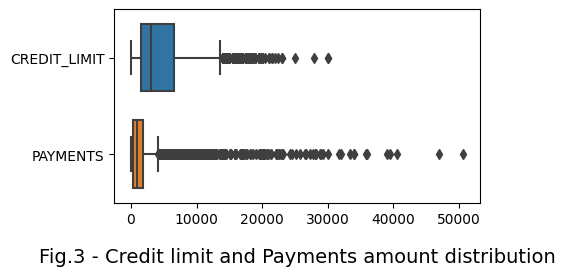

In [25]:
plot_counter = 3
plt.figure(figsize=(5,3))
fig = sns.boxplot(data[['CREDIT_LIMIT', 'PAYMENTS']], orient='h', width=0.7)
#fig.set_xscale('log')

fig.set_title(f'Fig.{plot_counter} - Credit limit and Payments amount distribution', y=-0.35, size=14)
ax.set_xlabel('Amount')
plt.tight_layout();

#plt.savefig(os.path.join(figures_path, f'fig_{plot_counter}.png'))

10. visualization

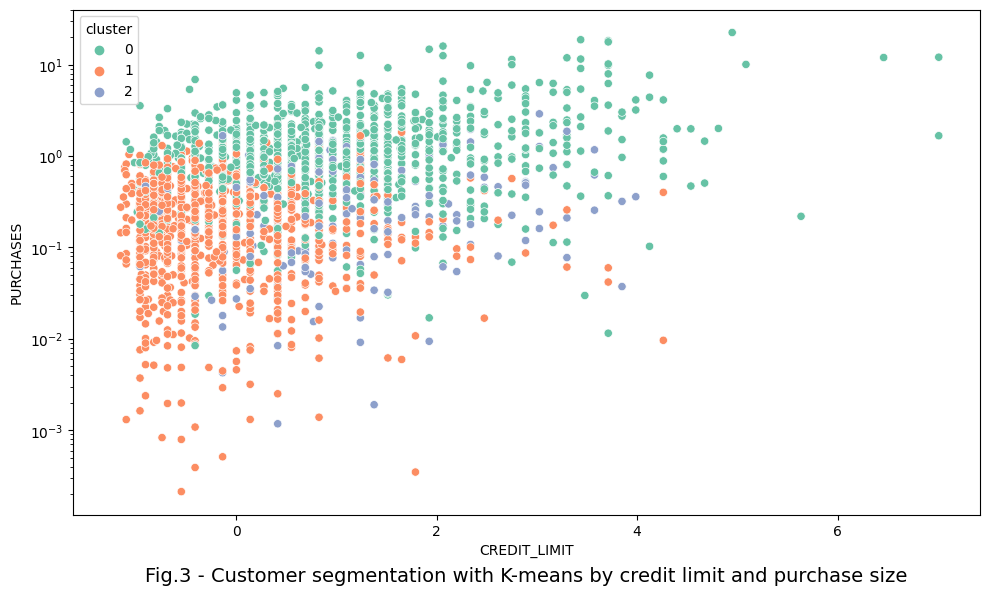

In [ ]:
# kmeans = KMeans(n_clusters=3, n_init=10, random_state=42)
# kmeans.fit(X_scaled)
# X_scaled['cluster'] = kmeans.labels_

# plot_counter = 3
# plt.figure(figsize=(10,6))
# fig = sns.scatterplot(data=X_scaled, x='CREDIT_LIMIT', y='PURCHASES', hue='cluster', palette="Set2")#;  size="TENURE", sizes=(20, 200),
# fig.set_yscale('log')
# fig.set_title(f'Fig.{plot_counter} - Customer segmentation with K-means by credit limit and purchase size', y=-0.15, size=14);
# plt.tight_layout()

# #plt.savefig(os.path.join(figures_path, f'fig_{plot_counter}.png'))

The Fig.5 represents the customer segmentation using the K-means algorythm. The figure shows following groups:
* cluster 0 contains customers with low credit limit

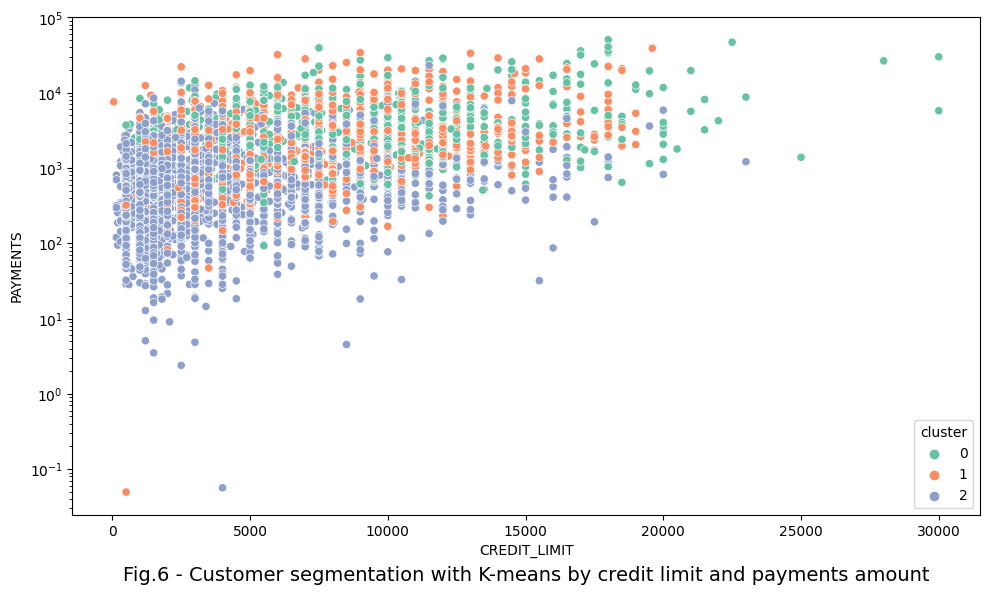

In [ ]:
# plot_counter = 6
# plt.figure(figsize=(10,6))
# fig = sns.scatterplot(data=data, x='CREDIT_LIMIT', y='PAYMENTS', hue='cluster', palette="Set2")#;  size="TENURE", sizes=(20, 200),
# fig.set_yscale('log')
# fig.set_title(f'Fig.{plot_counter} - Customer segmentation with K-means by credit limit and payments amount', y=-0.15, size=14);
# plt.tight_layout()

# #plt.savefig(os.path.join(figures_path, f'fig_{plot_counter}.png'))

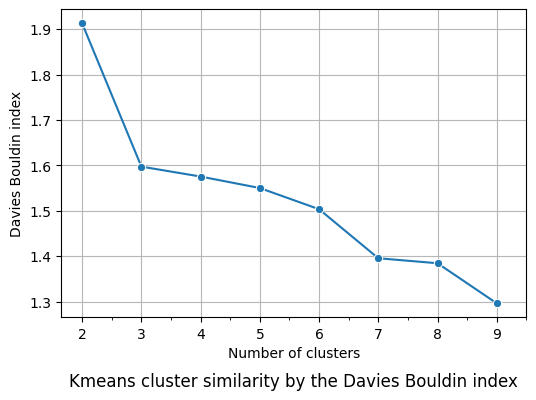

In [35]:
def get_db_score(cluster_num:int, X:pd.DataFrame)->pd.DataFrame:
    """Calculate the extent of cluster uniqueness by the davies_bouldin_score

    Args:
        cluster_num (int): number of clusters for estimation
        X (pd.DataFrame): feature matrix

    Returns:
        float: davies_bouldin_score
    """    
    kmeans =  KMeans(n_clusters=cluster_num, n_init=10, random_state=random_seed)
    kmeans.fit_predict(X)
    return davies_bouldin_score(X, kmeans.labels_)

# empty dict to store Davies Bouldin indexes and numbers of clusters
db_res = {"db_score": [], "cluster": []}

 
for cluster_num in range(2, 10):
    db_res["db_score"].append(get_db_score(cluster_num, X_scaled))
    db_res["cluster"].append(cluster_num)
    
 
db_df = pd.DataFrame(db_res)

fig, ax = plt.subplots(figsize = (6, 4))

sns.lineplot(data=db_df, x="cluster", y="db_score", marker= "o",ax=ax)

minor_ticks = np.arange(2, 10, 0.5)
major_ticks = np.arange(2, 10, 1)
ax.set_xticks(minor_ticks, minor=True)
ax.grid(which='major', alpha=0.9)
ax.set_ylabel('Davies Bouldin index')
ax.set_xlabel('Number of clusters')
ax.set_title('Kmeans cluster similarity by the Davies Bouldin index', y=-0.25);
#ax.grid(which='minor', alpha=0.2);

[-1.22143228 -1.19394842 -1.18020649 -1.09775489  0.4138576   0.4550834
  0.4138576  -0.13581967 -0.4106583  -0.85040012 -1.22143228] [ 2.01632521 -0.55736499 -0.56604659 -0.59868826 -0.59868826 -0.51081206
 -0.3096241   1.40789357  2.18720627  2.60764721  2.01632521]
[ 5.63579168e+00  7.00998486e+00  2.88740533e+00  1.23837351e+00
  1.39018967e-01 -5.48077623e-01 -5.48077623e-01  1.59964895e-03
  1.39018967e-01  4.13857603e-01  4.68825330e-01  5.51276921e-01
  4.12417919e+00  5.63579168e+00] [-0.11882125  1.3954425   2.34401779  2.69939316  2.84214756  2.90140684
  2.760621    0.99997459  0.56296664 -0.29981498 -0.4193853  -0.59868826
 -0.59868826 -0.11882125]
[ 5.08611441  7.00998486  4.94869509  3.71192123  0.82611556 -0.54807762
 -0.90536785 -0.4106583   0.4138576   2.47514737  4.67385646  5.08611441] [ 2.42761806  9.77437956 15.61277519 16.92227897 13.03284938  7.03524131
  3.71421519  3.1644023   2.88308326  2.53068966  2.20973576  2.42761806]


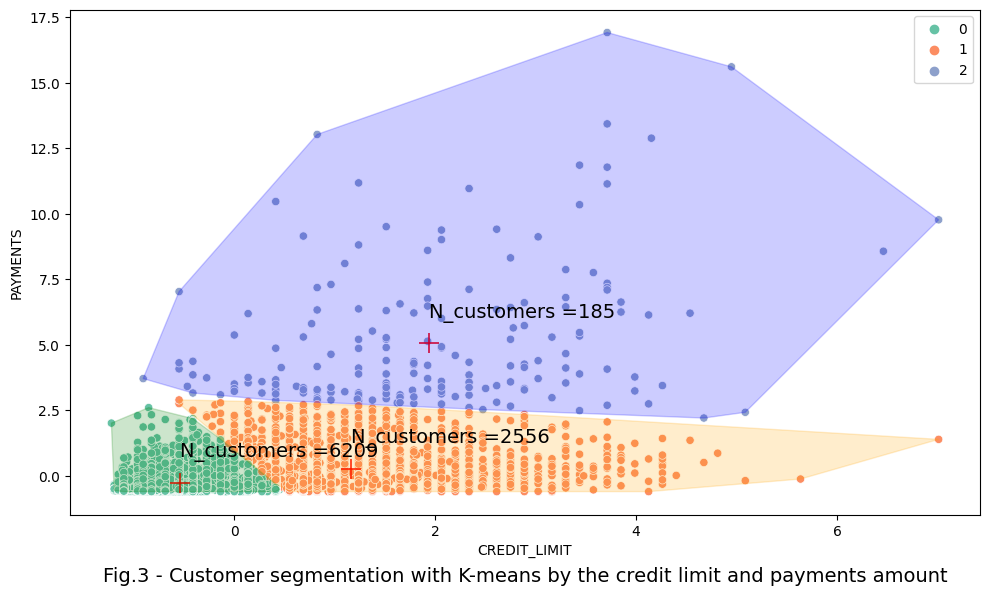

In [57]:
kmeans = KMeans(n_clusters=3, n_init=10, random_state=random_seed)
cols = ['CREDIT_LIMIT', 'PAYMENTS']
kmeans.fit(X_scaled[cols])
X_scaled.loc[:,'cluster'] = kmeans.labels_
#data.loc[:,'cluster'] = kmeans.labels_ 
# centroid
centroid = pd.DataFrame(kmeans.cluster_centers_, columns=['cen_x', 'cen_y'])

plot_counter = 3
plt.figure(figsize=(10,6))
fig = sns.scatterplot(data=X_scaled, x='CREDIT_LIMIT', y='PAYMENTS', hue='cluster', palette="Set2" )
fig = sns.scatterplot(data=centroid, x='cen_x', y='cen_y', marker="+", c='r', s=200) ;

colors = ['green', 'orange', 'blue']

# get unique values within the cluster
for i in X_scaled['cluster'].unique():
    
    points = X_scaled[X_scaled['cluster'] == i][cols].values
    hull = ConvexHull(points)

    # get shell coordinates by x and y axis. Add 0 elementh to enclose the shape
    x_hull = np.append(points[hull.vertices, 0], points[hull.vertices, 0][0]) 
    y_hull = np.append(points[hull.vertices, 1], points[hull.vertices, 1][0]) 
    #print(x_hull, y_hull)
    
    # plot and fill the shell
    plt.fill(x_hull, y_hull, alpha=0.2, c=colors[i])
    
#fig.set_yscale('log')
#fig.set_xscale('log')

num_customers = list(np.unique(kmeans.labels_, return_counts=True)[1])

for i,v in enumerate(num_customers):
    plt.annotate(f'N_customers ={v}', xy=(centroid.iloc[i][0], centroid.iloc[i][1]+1), size=14)
#plt.legend(['0 - N=6209', '1 - N=2556', '2 - N=185'],)

fig.set_title(f'Fig.{plot_counter} - Customer segmentation with K-means by the credit limit and payments amount', y=-0.15, size=14);
plt.tight_layout()

#plt.savefig(os.path.join(figures_path, f'fig_{plot_counter}.png'))

## Payments forecasting

### Cluster 0

In [58]:
temp = X_scaled[X_scaled['cluster']==0]
X, Y = temp.drop(['PAYMENTS'], axis=1), temp['PAYMENTS']
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=random_seed)

#### linear regression

In [59]:
# Creation an instance
lr = LinearRegression()

# Training the model
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

print(f'R2 score: { round(r2_score(y_test, y_pred),3)}')
print(f'RMSE score: { round(mean_squared_error(y_test, y_pred, squared = False),3)}')
print(f'MAPE score: { round(mean_absolute_percentage_error(y_test, y_pred),3)}')

R2 score: 0.476
RMSE score: 0.273
MAPE score: 1.433


In [60]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor().fit(X_train, y_train)

y_pred = rf.predict(X_test)

print(f'R2 score: { round(r2_score(y_test, y_pred),3)}')
print(f'RMSE score: { round(mean_squared_error(y_test, y_pred, squared = False),3)}')
print(f'MAPE score: { round(mean_absolute_percentage_error(y_test, y_pred),3)}')

R2 score: 0.615
RMSE score: 0.234
MAPE score: 0.972


#### Gradient boosting

In [61]:
def optuna_gbr(trial):
    """
    Hyperparameters optimization for gradient boosting regressor model

    Args:
        trial (_type_): iteration

    Returns:
        (float) r2_score, rmse_score
    """    
    # set dimensions
    n_estimators = trial.suggest_int('n_estimators', 40, 300, 1)
    max_depth = trial.suggest_int('max_depth', 3, 7, 1)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.2)
    min_samples_leaf = trial.suggest_int('max_depth', 2, 15, 1)
   
    # model creation 
    model = GradientBoostingRegressor(
        max_depth=max_depth,
        n_estimators=n_estimators,
        max_features=1,
        min_samples_leaf = min_samples_leaf,
        learning_rate=learning_rate,
        random_state=random_seed
    )
    
    # training
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    r_score = r2_score(y_test, y_pred)
    #rmse_score = mean_squared_error(y_test, y_pred, squared = False)
 
    return r_score #, rmse_score

In [62]:
%%time
# create study set
study = optuna.create_study(study_name="gbr", direction="maximize", sampler=sampler)
# try multiple times
study.optimize(optuna_gbr, n_trials=100)

clear_output(wait=False)

best_hyperparameters = study.best_params
print(f"\tparams: {best_hyperparameters}")

display(optuna.visualization.plot_optimization_history(study, target_name="r_score"))

	params: {'n_estimators': 241, 'max_depth': 5, 'learning_rate': 0.0876020108774834}


CPU times: total: 42.8 s
Wall time: 43 s


In [63]:
# Create the model
gbr = GradientBoostingRegressor(**best_hyperparameters,random_state=random_seed, verbose=0)

# Training the model
gbr.fit(X_train, y_train)

# предсказание
y_pred_train, y_pred_test =  gbr.predict(X_train), gbr.predict(X_test)


print(f'R2 score: { round(r2_score(y_test, y_pred_test),3)}')
print(f'RMSE score: { round(mean_squared_error(y_test, y_pred_test, squared = False),3)}')
print(f'MAPE score: { round(mean_absolute_percentage_error(y_test, y_pred_test),3)}')

R2 score: 0.618
RMSE score: 0.233
MAPE score: 0.874


In [64]:
def get_score(label, y, y_hat):
    
    R2_score = r2_score(y, y_hat)
    RMSE_score = mean_squared_error(y, y_hat, squared = False)
    MAPE_score = mean_absolute_percentage_error(y, y_hat)
    print("{}\t{:.3f}\t\t{:.3f}\t\t{:.3f}".format(label, R2_score, RMSE_score, MAPE_score))

print(50 * "_")
print("sample\tR2 score\tRMSE score\tMAPE score")
get_score('train', y_train, y_pred_train)
get_score('test', y_test, y_pred_test)
print(50 * "_")

__________________________________________________
sample	R2 score	RMSE score	MAPE score
train	0.913		0.107		0.811
test	0.618		0.233		0.874
__________________________________________________


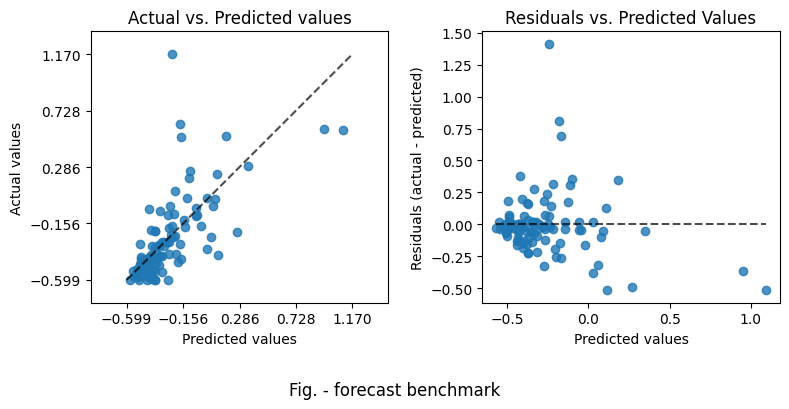

In [65]:
fig, ax = plt.subplots(ncols=2, figsize=(8, 4))
PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred=y_pred_test,
    kind="actual_vs_predicted",
    subsample=100,
    ax=ax[0],
    random_state=0,
)
ax[0].set_title("Actual vs. Predicted values")

PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred=y_pred_test,
    kind="residual_vs_predicted",
    subsample=100,
    ax=ax[1],
    random_state=0,
)
ax[1].set_title("Residuals vs. Predicted Values")
fig.suptitle("Fig. - forecast benchmark", y=-0.05)
plt.tight_layout()

### Feature analysis

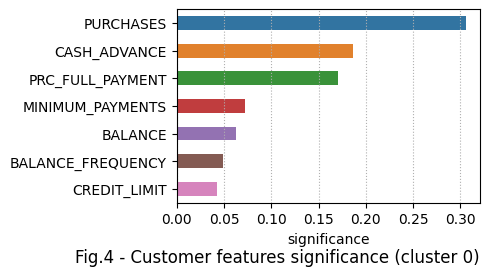

In [66]:
factors = pd.DataFrame({'significance':gbr.feature_importances_}, index=X_train.columns).sort_values(by='significance', ascending=False).iloc[:7]

plot_counter=4

# display first 7 most significant features
fig, ax = plt.subplots(figsize=(5, 3))
sns.barplot(factors, x='significance', y=factors.index, width=0.5)
ax.set_title(f'Fig.{plot_counter} - Customer features significance (cluster 0)', y=-0.35, loc='right'); 
plt.tight_layout()
ax.xaxis.grid(linestyle=':');

plt.savefig(os.path.join(figures_path, f'fig_{plot_counter}.png'))

In [67]:
temp = data[data['cluster']==0][['PRC_FULL_PAYMENT', 'BALANCE_FREQUENCY']]
plt.figure(figsize=(4,2))
sns.boxplot(temp, orient='h', width=0.7)

KeyError: 'cluster'

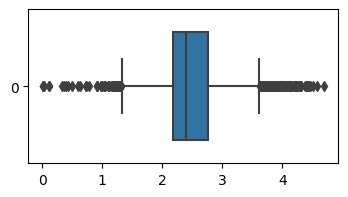

In [ ]:
temp = data[data['cluster']==0]['MINIMUM_PAYMENTS']
plt.figure(figsize=(4,2))
sns.boxplot(np.log10(temp+1), orient='h', width=0.7);

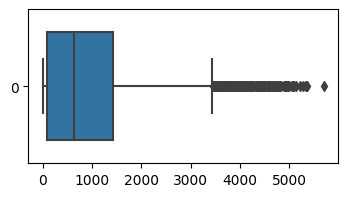

In [ ]:
temp = data[data['cluster']==0]['BALANCE']
plt.figure(figsize=(4,2))
sns.boxplot(temp, orient='h', width=0.7);

In [ ]:
data[data['cluster']==0]['BALANCE'].describe()

count    6209.000000
mean      936.338551
std      1028.333399
min         0.000000
25%        80.513636
50%       635.090434
75%      1420.156349
max      5709.486507
Name: BALANCE, dtype: float64

## Cluster 1

In [ ]:
temp = X_scaled[X_scaled['cluster']==1]
X, Y = temp.drop(['PAYMENTS'], axis=1), temp['PAYMENTS']
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=random_seed)

In [ ]:
%%time
# create study set
study = optuna.create_study(study_name="gbr", direction="maximize", sampler=sampler)
# try optimization multiple times
study.optimize(optuna_gbr, n_trials=100)

clear_output(wait=False)

best_hyperparameters = study.best_params
print(f"\tparams: {best_hyperparameters}")

optuna.visualization.plot_optimization_history(study, target_name="r_score")

	params: {'n_estimators': 271, 'max_depth': 6, 'learning_rate': 0.04044636521805404}
CPU times: total: 25 s
Wall time: 25 s


In [ ]:
# Create the model
gbr = GradientBoostingRegressor(**best_hyperparameters,random_state=random_seed, verbose=0)

# Training the model
gbr.fit(X_train, y_train)

# предсказание
y_pred_train, y_pred_test =  gbr.predict(X_train), gbr.predict(X_test)


print(f'R2 score: { round(r2_score(y_test, y_pred_test),3)}')
print(f'RMSE score: { round(mean_squared_error(y_test, y_pred_test, squared = False),3)}')
print(f'MAPE score: { round(mean_absolute_percentage_error(y_test, y_pred_test),3)}')

R2 score: 0.571
RMSE score: 0.51
MAPE score: 2.602


In [ ]:
print(50 * "_")
print("sample\tR2 score\tRMSE score\tMAPE score")
get_score('train', y_train, y_pred_train)
get_score('test', y_test, y_pred_test)
print(50 * "_")

__________________________________________________
sample	R2 score	RMSE score	MAPE score
train	0.920		0.208		3.357
test	0.571		0.510		2.602
__________________________________________________


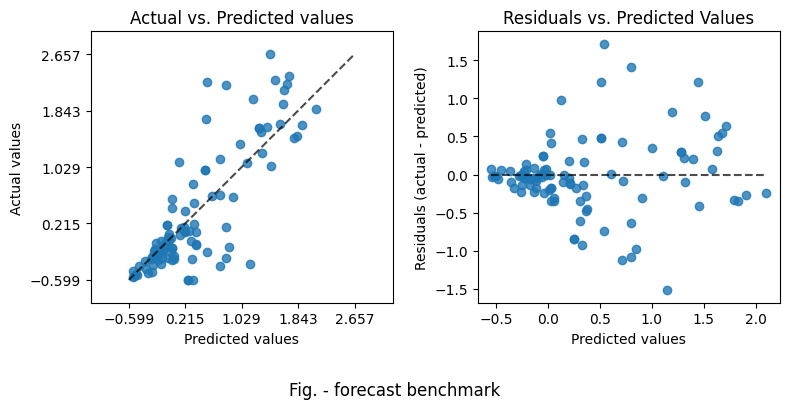

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(8, 4))
PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred=y_pred_test,
    kind="actual_vs_predicted",
    subsample=100,
    ax=ax[0],
    random_state=0,
)
ax[0].set_title("Actual vs. Predicted values")

PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred=y_pred_test,
    kind="residual_vs_predicted",
    subsample=100,
    ax=ax[1],
    random_state=0,
)
ax[1].set_title("Residuals vs. Predicted Values")
fig.suptitle("Fig. - forecast benchmark", y=-0.05)
plt.tight_layout()

### Feature analysis

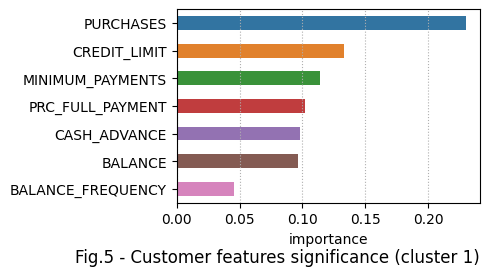

In [ ]:
factors = pd.DataFrame({'importance':gbr.feature_importances_}, index=X_train.columns).sort_values(by='importance', ascending=False).iloc[:7]

plot_counter=5

# display first 7 most significant features
fig, ax = plt.subplots(figsize=(5, 3))
sns.barplot(factors, x='importance', y=factors.index, width=0.5)
ax.set_title(f'Fig.{plot_counter} - Customer features significance (cluster 1)', y=-0.35, loc='right'); 
plt.tight_layout()
ax.xaxis.grid(linestyle=':');
#ax.set_xscale('log')
plt.savefig(os.path.join(figures_path, f'fig_{plot_counter}.png'))

## Cluster 2

In [ ]:
temp = X_scaled[X_scaled['cluster']==2]
X, Y = temp.drop(['PAYMENTS'], axis=1), temp['PAYMENTS']
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=random_seed)

In [ ]:
%%time
# create study set
study = optuna.create_study(study_name="gbr", direction="maximize", sampler=sampler)
# try optimization multiple times
study.optimize(optuna_gbr, n_trials=100)

clear_output(wait=False)

best_hyperparameters = study.best_params
print(f"\tparams: {best_hyperparameters}")
optuna.visualization.plot_optimization_history(study, target_name="r_score")

	params: {'n_estimators': 95, 'max_depth': 4, 'learning_rate': 0.18182233115333946}
CPU times: total: 5.8 s
Wall time: 5.81 s


In [ ]:
# Create the model
gbr = GradientBoostingRegressor(**best_hyperparameters, random_state=random_seed, verbose=0)

# Training the model
gbr.fit(X_train, y_train)

# предсказание
y_pred_train, y_pred_test =  gbr.predict(X_train), gbr.predict(X_test)


print(f'R2 score: { round(r2_score(y_test, y_pred_test),3)}')
print(f'RMSE score: { round(mean_squared_error(y_test, y_pred_test, squared = False),3)}')
print(f'MAPE score: { round(mean_absolute_percentage_error(y_test, y_pred_test),3)}')

R2 score: 0.342
RMSE score: 2.501
MAPE score: 0.332


In [ ]:
print(50 * "_")
print("sample\tR2 score\tRMSE score\tMAPE score")
get_score('train', y_train, y_pred_train)
get_score('test', y_test, y_pred_test)
print(50 * "_")

__________________________________________________
sample	R2 score	RMSE score	MAPE score
train	1.000		0.030		0.006
test	0.342		2.501		0.332
__________________________________________________


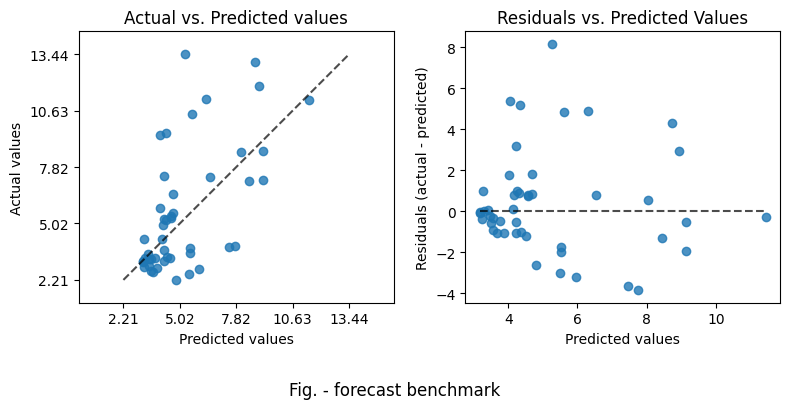

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(8, 4))
PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred=y_pred_test,
    kind="actual_vs_predicted",
    subsample=100,
    ax=ax[0],
    random_state=0,
)
ax[0].set_title("Actual vs. Predicted values")

PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred=y_pred_test,
    kind="residual_vs_predicted",
    subsample=100,
    ax=ax[1],
    random_state=0,
)
ax[1].set_title("Residuals vs. Predicted Values")
fig.suptitle("Fig. - forecast benchmark", y=-0.05)
plt.tight_layout()

### Feature analysis

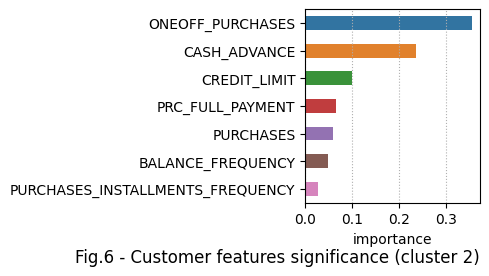

In [ ]:
factors = pd.DataFrame({'importance':gbr.feature_importances_}, index=X_train.columns).sort_values(by='importance', ascending=False).iloc[:7]

plot_counter=6

# display first 7 most significant features
fig, ax = plt.subplots(figsize=(5, 3))
sns.barplot(factors, x='importance', y=factors.index, width=0.5)
ax.set_title(f'Fig.{plot_counter} - Customer features significance (cluster 2)', y=-0.35, loc='right'); 
plt.tight_layout()
ax.xaxis.grid(linestyle=':');
#ax.set_xscale('log')
plt.savefig(os.path.join(figures_path, f'fig_{plot_counter}.png'))